# CSE5CV - Azure Services

In this weeks lab we'll have a crash course on training and using computer vision models with Microsoft Azure. Specifically:

* Understand Azure terms like "Cognitive Services", "resources", etc.
* Fine-tune an image classification model to classify fruit.
* Train and deploy models onto Azure with zero code.
* Interact with deployed models with python.
* Use various other Cognitive Services available through Azure:
    * Image captioning
    * Optical Character Recognition
    * Face Detection
* A brief discussion of ethics in AI with respect to evaluating emotion from images.

## Colab preparation

Google Colab is a free online service for editing and running code in notebooks like this one. To get started, follow the steps below:

1. Click the "Copy to Drive" button at the top of the page. This will open a new tab with the title "Copy of...". This is a copy of the lab notebook which is saved in your personal Google Drive. **Continue working in that copy, otherwise you will not be able to save your work**. You may close the original Colab page (the one which displays the "Copy to Drive" button).
2. Run the code cell below to prepare the Colab coding environment by downloading sample files. Note that if you close this notebook and come back to work on it again later, you will need to run this cell again.

In [ ]:
!git clone https://github.com/ltu-cse5cv/cse5cv-labs.git
%cd cse5cv-labs/Lab09

## Packages

This week we're introducing some new packages for communicating with Azure from Python scripts.

You will need to install additional pip packages which provide support for Azure. The code in the following cell will install these packages in the notebook environment.

In [ ]:
%pip install azure-cognitiveservices-vision-customvision~=3.1.0 \
             azure-cognitiveservices-vision-computervision~=0.9.0 \
             azure-ai-formrecognizer~=3.1.2

In [ ]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential
from msrest.authentication import ApiKeyCredentials, CognitiveServicesCredentials

# Utility functions
def load_image_rgb(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def display_image(image, title=None):
    fig, axes = plt.subplots(figsize=(12, 8))

    if image.ndim == 2:
        axes.imshow(image, cmap='gray', vmin=0, vmax=255)
    else:
        axes.imshow(image)

    axes.axis('off')

    if title is not None:
        plt.title(title)

    plt.show()

### Azure Python SDK
Provides extremely simple access to the Custom Vision and Cognitive Services through python. Behind the scenes, the objects perform REST requests to the servers.

This SDK is split up over several different python packages. We use 4 different packages in this lab:

1. `azure-cognitiveservices-vision-customvision`: for CustomVisionPredictionClient.
2. `azure-cognitiveservices-vision-computervision`: for ComputerVisionClient.
4. `azure-ai-formrecognizer`: for FormRecognizerClient.

Note that the credentials are pre-requisites of the above packages and were installed alongside the above packages.

Package Homepage: https://github.com/Azure/azure-sdk-for-python

# 1. Azure introduction

Microsoft Azure is a cloud provider with sophisticated UIs and libraries to create and deploy various machine learning models to publicly available URLs. If you wanted to create an app that classifies images from your phone's camera, you could use Azure to host the computer vision model that does that classification on the cloud.

Microsoft Azure has some terminology we would like to highlight to you:

**Free tier**: Cloud providers will charge you for using their services. There is a free tier for students with Azure. You should be careful to only do the tasks we describe, and careful to clean up your provisioned resources.

**Resource**: In this lab, a virtual machine for running jobs hosted on Azure's cloud infrastructure.

**Custom Vision Resource**: A type of resource provided by Azure for easily creating custom cloud-hosted computer vision models. We don't need to configure it at all, we just need to populate it with models (see Section 2).

**Cognitive Services Resource**: A type of resource provided by Azure for performing some predefined operations on images using AI:
  * Image captioning.
  * Image detection.
  * Location and approximate age of human faces in the image.
  * Automatic tagging.
    * Whether the image contains any 'adult', 'racy', or 'gory' content.


**Resource Group**: Your resources are organised into "Resource groups". These are groups of virtual machines that work together on whatever you like. When you create a Custom Vision resource, Azure creates two resources at once: a "training" and "prediction" resource. Your running resources can be viewed here: https://portal.azure.com/#blade/HubsExtension/BrowseResourceGroups

**Project**: The training/deployment of a single computer vision model onto a resource.

**Model**: Just like we have done in the labs, a "model" is a function which takes an image and produces predictions. In this case, a model will be trained and deployed to a resource, and interacted with using a REST API through a Custom Vision client object (see Section 2).

## 1.1 Create resources/resource group

This lab is split up into several "projects". These projects will share the same Azure "resources". So, you will only need to create these resources once for this lab, and they will be re-used for all the projects. However, when you are done with the lab, make sure you remove those resources (see Section 1.2).

**Task**: Create two resources in a single resource group. We will create a "Custom Vision" and a "Cognitive Services" resource for use in this lab. We will first go through creating a "Custom Vision" resource and then creating a "Cognitive Services" resource.

The starting point for creating any resource on Azure is to visit: https://portal.azure.com. Make sure you are logged in with your new account (use a separate private window if you need).

### 1.1.1 Custom Vision

Starting from: https://portal.azure.com:

1. Click "Create a Resource"
2. Search for "Custom Vision"
3. Select "Custom Vision" and then click "Create"
4. Create a new resource group by clicking "Create new" under "Resource Group". Name it "CSE5CV-Azure".
5. Enter a unique instance name including your student ID and "customvision". For example, `22222222customvision`.
6. Select the free tier for both training and prediction.
7. Click "Review + Create". Then click "Create".

### 1.1.2 Cognitive Services

Starting from: https://portal.azure.com

1. Click "Create a Resource".
2. Search "Cognitive Services".
3. Click "Create"
4. Assign the Cognitive Services resource to the same resource group as before.
5. Enter a unique instance name including your student ID and "cognitiveservices". For example, `22222222cognitiveservices`.
6. Read and if you accept the conditions, tick the box.
7. Review and create

## 1.2 Deleting resource groups

**Important**: **To do only when you are done with this lab**

*When you are done with this lab* you can follow these instructions to delete your resource group. This will remove all of the resources you created in one go: the Custom Vision resources and the Cognitive Services resources.

1. Visit https://portal.azure.com/#blade/HubsExtension/BrowseResourceGroups.
2. Select resource group (click the name)
3. Click "Delete resource group"
4. Enter the name "CSE5CV-Azure" (this is a clever UI to ensure that you are deleting the resource group you intend to).
5. Click "Delete".

![Deleting resource group](https://github.com/ltu-cse5cv/cse5cv-labs/blob/master/Lab09/img/present/delete-resource-group.png?raw=1)

## 1.3 Collect communication credentials

These resources come pre-configured to receive REST requests. However, they are not open to the world; you need to use specific credentials to access them. Here we describe how to get the credentials for each of the resources.

### 1.3.1 Custom Vision

We will eventually create models for the "Custom Vision" resources to use for prediction. We will choose which model to access using the project id and model's name. However, all of the REST requests will go to the same resource using the same credentials.

**Task**: Collect your custom vision resource's REST credentials from Azure.

1. Visit http://portal.azure.com
2. Search "All Resources" in the top bar
3. Select the "Custom vision" item ending in "-Prediction" (click its name)
4. Select "Keys and Endpoint"
5. Copy "Key 1" and "Endpoint" into `custom_vision_key` and `custom_vision_endpoint` respectively in the next code cell.

In [ ]:
# TODO: fill with your data
custom_vision_key = ''
custom_vision_endpoint = ''

custom_vision_credentials = ApiKeyCredentials(
    in_headers={"Prediction-key": custom_vision_key}
)
custom_vision_client = CustomVisionPredictionClient(
    endpoint=custom_vision_endpoint,
    credentials=custom_vision_credentials
)

Now we have an object `custom_vision_client` which can interact with our hosted resource very easily. Eventually we will be calling `custom_vision_client.classify_image()`, but first we need to host/deploy a model on the resource.

### 1.3.2 Cognitive Services

**Task**: Collect your cognitive services resource's REST credentials from Azure.

1. Visit http://portal.azure.com
2. Search "All Resources" in the top bar
3. Select the "Cognitive services multi-service account" item (click its name)
4. Select "Keys and Endpoint"

![Cognitive services credentials](https://github.com/ltu-cse5cv/cse5cv-labs/blob/master/Lab09/img/present/credentials-cognitive-services.png?raw=1)

5. Copy "Key 1" and "Endpoint" into `cog_key` and `cog_endpoint` respectively in the next code cell.

In [ ]:
# TODO: Copy values into the following variables
cog_key = ''
cog_endpoint = ''

# Initialise credential objects
cog_credentials = CognitiveServicesCredentials(cog_key)
key_credentials = AzureKeyCredential(cog_key)

# Instantiate client objects for interaction with Cognitive Services server
cog_client = ComputerVisionClient(cog_endpoint, cog_credentials)
form_rec_client = FormRecognizerClient(cog_endpoint, key_credentials)

# 2. Classify fruit

We will use a Custom Vision web interface provided by Azure to train a fruit classification model. After we create the model, we will deploy it onto our Custom Vision resource, and send images to be classified from this notebook using a REST API through the `custom_vision_client` we created in section 1.3.1.

This project operates entirely within free services, and will not deduct from your credits.

## 2.1 Create a new project

Visit: https://www.customvision.ai

The free tier of Azure only allows you to have one free project running at once. Make sure you have closed any other projects.

**Task**: Create a new project with the following settings:
* **Name**: Fruit Classifier
* **Description**: Image classification for fruit
* **Resource**: (select the name of your Custom Vision resource that you created at the start)
* **Project Types**: Classification
* **Classification Types**: Multiclass
* **Domains**: Food

## 2.2 Upload training images

**Task**: Upload all of your training images.
1. Download and extract the following .zip archive containing fruit images: https://github.com/ltu-cse5cv/cse5cv-labs/releases/download/v0.0.0/fruit.zip
2. Back on the Custom Vision web page, click "Add images".
3. Navigate to `fruit/train/apple`. Use shift to select all the images in this folder. Type "apple" into the "My Tags" field.
4. Repeat steps 1 and 2 for "banana" and "orange".

**Question**: How many training images do we have? How many classes?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

We have 45 training images over 3 classes: "apple", "banana", "orange" (15 images each).
</details>

## 2.3 Train model

**Task**: Click the green "Train" button in the top-right. Choose "Quick Training". Click "Train".

While it is training, we will collect the project id.

**Task**: Click the cog in the top-right to get to the project settings. You will see the "Project id" like this:

![Fruit project id](https://github.com/ltu-cse5cv/cse5cv-labs/blob/master/Lab09/img/present/fruit-project-id.png?raw=1)

Record the "Project Id" in the `project_id` variable in the next cell.

In [ ]:
# TODO: Fill in project id
project_id = ''

**Task**: Click "Performance" in the top-right. Wait patiently for your model to finish training. It will take about 5 minutes. Do some breathing exercises. Meditate. Whatever.

## 2.4 Deploy model

When your model has finished training you will be presented with a page showing precision, recall, and AP performance metrics.

**Task**: Click "Publish". Choose the model name "fruit1" and your prediction resource.

In the next cell we interact with the model that we just trained and published/deployed on our resource. Publishing is instant; you can run the next cell right away.

In [ ]:
model_name = 'fruit1'

with open(Path('fruit', 'test', 'IMG_TEST_1.jpg'), 'rb') as f:
    response = custom_vision_client.classify_image(project_id, model_name, f.read())

# The predictions are returned in descending order of probability,
# so we choose the first as the "prediction"
print('The whole response:    -------')
print(response)
print('------------------------------')
print()
print('Our model predicted: ', response.predictions[0].tag_name)

**Question**: If we get more training data, how should we use this interface to train a new model and publish it? How will we tell the resource that we want to use the new model?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

We would add new images under the "Training Images" tab, making sure to label them all. Then, we can run "Quick Train" again, training a new model on the whole dataset. When we publish, we must call it something else. Perhaps "fruit2". Then, when we call `custom_vision-client.classify_image(...)`, we need to make sure we pass the correct `model_name`.
</details>

## 2.5 Test model

Next we will visually evaluate all of our test images.

In [ ]:
test_image_paths = list(Path('fruit', 'test').iterdir())
fig = plt.figure(figsize=(16, 10))
cols = 3
rows = len(test_image_paths)//cols

for i, fpath in enumerate(test_image_paths):
    # Get prediction from our service
    with open(fpath, 'rb') as f:
        response = custom_vision_client.classify_image(project_id, model_name, f.read())
    pred = response.predictions[0].tag_name

    # Load image data into numpy array with opencv
    img = load_image_rgb(str(fpath))

    # Display the image with it's prediction
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.imshow(img)
    ax.set_title(pred)

plt.show()

**Question**: How did the model do?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

Tutor: My model got all of them correct. This is a relatively easy task for modern deep learning, but, still. Good job, model!
</details>

## 2.6 Summary

You used www.customvision.ai to upload a training set for image classification, train a model and deploy it on Azure infrastructure. This model was accessible through a REST client. Azure provides a simple wrapper for us to use to communicate: `custom_vision_client`. In each request, we provided: `project_id`, `model_name` and some image data, and got back a prediction. Finally, we checked that it was working by sending unseen images.

## 2.7 Remove Project

The free tier only allows up to 2 projects active at once. Here are the instructions for removing this project.

1. Unpublish all of your models
2. Click the eye in the top left
3. Hover over your "Fruit Classifier" project and click the trash can

# 3. Describe Images

We will use our Cognitive Services resource to show off some simple use cases.

This project will deduct a small amount of credit from your free credits (\<$1).

In [ ]:
def load_and_detect(fpath, service):
    img = load_image_rgb(str(fpath))
    with open(fpath, 'rb') as f:
        detections = service(f)
    return img, detections

def display_image(img, figsize=(15, 10)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img)
    ax.axis('off')
    plt.show()

## 3.1 Image captioning

**Task**: Run the next code cell to use the Cognitive Services to obtain a text description of `'face/store_cam2.jpg'`.

In [ ]:
image_fpath = Path('face', 'store_cam2.jpg')
img, description = load_and_detect(image_fpath, cog_client.describe_image_in_stream)

print(description.captions[0].text)
display_image(img)

**Question**: Which line of code executes a REST request in the above code?
    
<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

The function call `cog_client.describe_image_in_stream(f)` executes a REST request to the Cognitive Services resource that we created at the beginning of the lab.
</details>
<br />

**Question**: Which line of code executes a REST request in the `load_and_detect` function above?
    
<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

The function call `service(f)` executes a REST request to the Cognitive Services resource that we created at the beginning of the lab. When a service call just requires the image, we'll use `load_and_detect` for brevity.
</details>

## 3.2 Object Detection

We can get the Cognitive Services resource to detect objects in our images. Unlike when we used MaskRCNN, the model is on their server, and we send the image to the server. Apart from that, it's very similar; we provide an image, we get detections back out, and we don't need to train anything ourselves, and we get pretty good results immediately.

In [ ]:
# Taken from Lab 4 (small modification to annotate_class)
COLOURS = [
    tuple(int(colour_hex.strip('#')[i:i+2], 16) for i in (0, 2, 4))
    for colour_hex in plt.rcParams['axes.prop_cycle'].by_key()['color']
]

def draw_detections(img, dets, colours=COLOURS):
    for i, (cl, tlx, tly, brx, bry) in enumerate(dets):
        i %= len(colours)
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=colours[i], thickness=2)

def annotate_class(img, dets, conf=None, colours=COLOURS):
    for i, (cl, tlx, tly, brx, bry) in enumerate(dets):
        txt = cl
        if conf is not None:
            txt += f' {conf[i]:1.3f}'
        # A box with a border thickness draws half of that thickness to the left of the
        # boundaries, while filling fills only within the boundaries, so we expand the filled
        # region to match the border
        offset = 1

        cv2.rectangle(img,
                      (tlx-offset, tly-offset-12),
                      (tlx-offset+len(txt)*12, tly),
                      color=colours[i],
                      thickness=cv2.FILLED)

        ff = cv2.FONT_HERSHEY_PLAIN
        cv2.putText(img, txt, (tlx, tly-1), fontFace=ff, fontScale=1.0, color=(255,)*3)

# Useful functions for Azure responses
def annotate_faces(img, dets, get_txt=None):
    faces = []
    for face in dets:
        r = face.face_rectangle
        tlx, tly, bw, bh = r.left, r.top, r.width, r.height
        txt = get_txt(face) if get_txt is not None else None
        faces.append((txt, tlx, tly, tlx+bw, tly+bh))
    draw_detections(img, faces)
    if get_txt is not None:
        annotate_class(img, faces)

In [ ]:
# Get image and analysis
image_fpath = Path('face', 'store_cam2.jpg')
img = load_image_rgb(str(image_fpath))
features = ['Description', 'Tags', 'Adult', 'Objects', 'Faces']
with open(image_fpath, 'rb') as f:
    analysis = cog_client.analyze_image_in_stream(f, visual_features=features)

# Draw all generic "objects"
if analysis.objects:
    objs = []
    for obj in analysis.objects:
        r = obj.rectangle
        tlx, tly, bw, bh = r.x, r.y, r.w, r.h
        objs.append((obj.object_property, tlx, tly, tlx+bw, tly+bh))
    draw_detections(img, objs, colours=[(255, 0, 0)]*len(objs))
    annotate_class(img, objs, colours=[(255, 0, 0)]*len(objs))

if analysis.faces:
    annotate_faces(img, analysis.faces, lambda face: f'Person aged {face.age}')

display_image(img)

**Question**: How many objects were detected (red bounding boxes)?
    
<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

There were 3 objects detected. All of them "Person" objects.
</details>
<br />

**Question**: What form were the bounding boxes returned from the server?
    
<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

The bounding boxes were returned in `tlx`,`tly`,`bw`,`bh` form as pixels. We convert these to `tlx`,`tly`,`brx`,`bry` form for compatibility with our previous lab's functions.
</details>
<br />

**Question**: How accurate do you think the age predictions are?
    
<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

You shouldn't guess someone's age. That's rude.
</details>

## 3.3 Optical Character Recognition (OCR)

Another common and useful task is detecting text in images, and storing the strings of that string in the image. Using Azure's Cognitive Services, we can detect where text is in the image, and what it says. The text is detected in regions, and each region is processed to produce a single string. As always, we don't have to do anything; Azure handles all the computer vision for us.

In [ ]:
# Send image to OCR endpoint
image_fpath = Path('ocr', 'advert.jpg')
service = cog_client.recognize_printed_text_in_stream
img, results = load_and_detect(image_fpath, service)

# Extract results
region_boxes = []
for i, region in enumerate(results.regions):
    for line in region.lines:
        # Get bounding box
        tlx, tly, bw, bh = [int(v) for v in line.bounding_box.split(',')]
        region_boxes.append((None, tlx, tly, tlx+bw, tly+bh))

        # Print detected words
        words = [word.text for word in line.words]
        print(f'Region {i}: ', ' '.join(words))

# Draw on and display image
draw_detections(img, region_boxes)
display_image(img)

**Question**: How many regions of text were detected?
    
<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

There were 2 regions of text detected.
</details>

### 3.3.1 Asynchronous OCR

You can obtain OCR asynchronously, receiving the regions of text as they become available, instead of waiting for the models on the server to finish processing. This is called the "Read API". Although in this case it only takes a few seconds, larger models or larger images with more text may take longer.

In [ ]:
# Load image and start async operation
image_fpath = Path('ocr', 'letter.jpg')
img = load_image_rgb(str(image_fpath))
with open(image_fpath, 'rb') as f:
    op = cog_client.read_in_stream(f, raw=True)

# Wait for the async operation to complete
op_id = op.headers['Operation-Location'].split('/')[-1]
while True:
    op_result = cog_client.get_read_result(op_id)
    if op_result.status not in [OperationStatusCodes.running]:
        break
    time.sleep(1)

# If it was successful print the results as before
if op_result.status == OperationStatusCodes.succeeded:
    for result in op_result.analyze_result.read_results:
        for line in result.lines:
            print(line.text)

# Display image
display_image(img)

**Question**: What is the name of the technique used to interact with the server in the section that uses a `while True:`?
    
<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

This is a general computing question. When the server responds immediately with an operation id which you can repeatedly query the server with, it is called "polling".
</details>

# 4. Detecting Faces

In earlier labs we showed a method for detecting and identifying faces. Azure provides tools to perform these tasks on their cloud infrastructure, but access to these are now restricted under a "Limited Access" scheme.

## 4.1 Ethical considerations

With the recent development of AI, especially in computer vision techniques, we must always strive to create technology that is used fairly and respectfully.

Some platforms, including Microsoft Azure, provide an endpoint to predict the emotions of each person just looking at their face.

We need to be very careful with a technology that has such potential to be misused in real-world scenarios.

Humans use facial expressions to communicate with others. That is, if someone is smiling, that person is telling others that they are happy. However, even within this simple rule there is nuance. A well known example is the contrast between Americans and Russians when it comes to smiling. Americans are known for smiling as a show of goodwill. If you do not smile in the US, generally you are communicating that there is something wrong. In contrast, Russians generally reserve smiling for when there is actually something worth smiling about. And that's just between cultures, there's a lot of variation between individuals (e.g. temperament, neurodiversity) and contexts too.

In [Emotional Expressions Reconsidered: Challenges to Inferring Emotion From Human Facial Movements](https://journals.sagepub.com/doi/10.1177/1529100619832930), Barrett et al. argue that all available evidence suggests that evaluating a person's emotions from their facial expression has: limited reliability, lack of specificity (recall) and limited generalisability. That is, determining emotion from facial expression - whether by human or machine - is not known to be accurate or reliable.

> \[Scientific\] frameworks propose that expressions of the same emotion category, such as anger, vary substantially across different people and situations. For example, when the goal of being angry is to overcome an obstacle, it may be more useful to scowl during some instances of anger, smile or laugh, or even stoically widen one’s eyes, depending on the temporospatial context.

So, the technology has fundamental limitations. What are the ethical problems with that? Here we present just two salient issues (although many more exist). The first is a privacy issue: many people do not want their emotional state to be evaluated without their permission, even if it is done anonymously and incorrectly. The second is an issue of fairness: if you do not conform to the algorithms idea of "positive" emotions, you are going to be unfairly targeted. So, consider two unethical uses of this technology currently underway:

 1. [*Monitoring shoppers in shopping centres*](https://www.theguardian.com/technology/2019/feb/24/are-you-being-scanned-how-facial-recognition-technology-follows-you-even-as-you-shop): Shopping centres are monitoring your emotions as you interact with advertisements using cameras attached to billboards. This is being done without anyone's consent in the name of improving their advertisements.
 2. [*Monitoring employees while they work*](https://www.insider.com/ai-emotion-recognition-system-tracks-how-happy-chinas-workers-are-2021-6): Some workplaces have started implementing cameras that monitor their employee's emotions and organising interventions if the workers show signs of negative emotions. This is being done to prevent violence, trouble-making and provide emotional support to workers.

**Question**: What is unethical about each case?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

In the first case, it is unethical to collect data about people without their permission. Since the individuals are not identified, there is no issue of fairness, since they won't be treated differently.

In the second case, there are a myriad of problems, just from the article, we can list at least 3 different ethical problems:
 1. Breaching your right to privacy at work.
 2. Stripping people of their right to freedom of expression by enforcing an algorithmic understanding of "positive" emotions.
 3. Creating perverse incentives to game the system.
</details>
<br />

**Question**: More generally, how can you tell if something is unethical?

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

In an ethical world people's rights are worth more than the money gained by denying those rights. It is important to look at the real world impact of a technology to make the most informed decision you can.
</details>
<br />

**In your own time**:
* Here is a brief summary of this area in 2019 https://partnershiponai.org/paper/the-ethics-of-ai-and-emotional-intelligence/
* Here is a specific, itemised list of ways to help identify ethical issues in AI usage https://t-guider.com/index.php/2021/04/06/identify-guiding-principles-for-responsible-ai/

**Remember**: Just because you can get a number out of your algorithm, doesn't mean that number is accurate or useful.

# 5. Receipts Recognizer

Consider the following image:

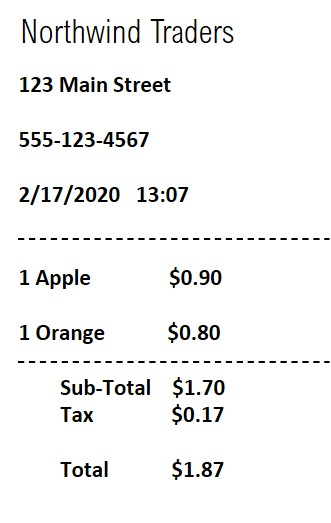

Reading the elements of this image is a type of optical character recognition (OCR).

**Task**: Go back to section 3.3 and run OCR on this receipt (the file path is `'ocr/receipt.jpg'`). Notice that each section of text is recognised, but that it does not come back with any information describing what each bit of text means. e.g. it recognises the text "$0.90", but it doesn't tell you that that is the price of one apple.

We can use a specific service for extracting labelled information from this receipt as shown below.

In [ ]:
img_fpath = Path('ocr', 'receipt.jpg')
with open(img_fpath, 'rb') as f:
    response = form_rec_client.begin_recognize_receipts(f)

# Collect result from server
receipt_data = response.result()
# Get data for first receipt (there was only one)
receipt = receipt_data[0]

# Some convenience methods for printing
def conditional_print(key, item):
    if item:
        print(f'{key}: {item.value}')

def get_field_and_print(receipt, field_name):
    field = receipt.fields.get(field_name)
    conditional_print(field_name, field)

# Print out the recognised header
get_field_and_print(receipt, 'ReceiptType')
get_field_and_print(receipt, 'MerchantAddress')
get_field_and_print(receipt, 'MerchantPhoneNumber')
get_field_and_print(receipt, 'TransactionDate')

# Print out all the recognised items in the receipt
items = receipt.fields.get("Items")
if items:
    for idx, item in enumerate(items.value):
        print(f'\tItem #{idx+1}')
        conditional_print(f'\t - Name', item.value.get('Name'))
        conditional_print(f'\t - Price', item.value.get('Price'))

# Print out the recognised footer
get_field_and_print(receipt, 'Subtotal')
get_field_and_print(receipt, 'Tax')
get_field_and_print(receipt, 'Total')

# API quiz

We've covered a lot of different services that you can call on Azure's systems. We will now review them with a quiz. (Go back to the relevant sections if you need, don't just look at the answers if you can't remember)

**Question**: What do each of these api calls do, and what arguments are needed? Write your answers on a piece of paper, in a text document or add a cell to record your answers before you look at the answer.
1. `custom_vision_client.classify_image`
2. `cog_client.describe_image_in_stream`
3. `cog_client.analyze_image_in_stream`
4. `cog_client.recognize_printed_text_in_stream`
5. Asynchronous:
    1. `cog_client.read_in_stream`
    2. `cog_client.get_read_result`
6. `form_rec_client.begin_recognize_receipts`
  

<details>
<summary style='cursor:pointer;'><u>Answer</u></summary>

1. `custom_vision_client.classify_image` is used to send an image to a custom model trained with Azure's Custom Vision projects for classification. It takes one argument: a file stream of the image to classify.
2. `cog_client.describe_image_in_stream` is used to caption an image using Cognitive Services. It takes one argument: a file stream of the image.
3. `cog_client.analyze_image_in_stream` is used to send an image to Cognitive Services for finding various features of arbitrary objects. It takes two arguments: a file stream of the image and a list of visual_features.
4. `cog_client.recognize_printed_text_in_stream` is used to find bounding boxes of text in an image and determine the content of those boxes (OCR). It takes one argument: a file stream of the image.
5. Asynchronous:
    1. `cog_client.read_in_stream` sends a request to the server to process the image, and returns immediately. It returns an object which can be polled to determine the status of the request. It takes at least one argument: a file stream of the image. When we provide the `raw=True` argument, it includes the HTTP headers in the response which we can parse. In this lab we used it for OCR, but it returns more than just OCR data.
    2. `cog_client.get_read_result` polls the server for the status of a request. It takes one argument: the id of the requested operation.
9. `form_rec_client.begin_recognize_receipts` is used to extract labelled OCR results from images of receipts with known keys. It takes one argument: a file stream of the image.
</details>


# Reminder: Shut down resource group

Make sure to close down the resource group when you are done. See section 1.2 for instructions.

# Summary

In this lab, you saw how to provision resources on Microsoft Azure's platform, and then interact with those resources with python. You saw several services that are provided out-of-the box from Azure with Cognitive Services, as well as how to train your own classification model with Custom Vision resources.